In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time

import model_short as model
import toy_data_loader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True, precision=3)

In [3]:
class hps:
    pass
hps.n_levels = 1 # number of splits
hps.depth = 1 # number of layers in revnet
hps.width = 4 # channels in revnet layers
hps.polyak_epochs = 1
hps.beta1 = .9 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.epochs = 10
hps.epochs_warmup = 2
hps.n_data = 4000 # should match the size of the input data
hps.batch_size = 25 # batch size
hps.n_batches = int(hps.n_data / hps.batch_size)
hps.n_bins = 2**8

In [4]:
sess = tf.InteractiveSession()

In [5]:
iterator, initialize_iterator, data_init = toy_data_loader.create_data_loader(
    sess, hps.batch_size, hps.n_data, hps.n_bins
)

W0202 01:31:52.594584 140590606984960 deprecation.py:323] From /home/tey/glow/toy_data_loader.py:35: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


(25, 256, 1)


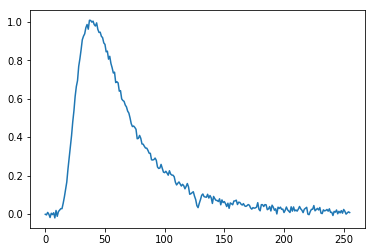

In [6]:
print(data_init.shape)
for spectrum in data_init:
    plt.plot(spectrum)
    break

In [6]:
def input_transform(tbl_batch):
    '''Define a transformation from table to batched data tensor.'''
    data = tbl_batch["spectrum"]
    mh_ratio, alpham_ratio = tbl_batch["MH_ratio"], tbl_batch["alphaM_ratio"]
    data_float = tf.to_float(data)
    mh_ratio_float, alpham_ratio_float = tf.to_float(mh_ratio), tf.to_float(alpham_ratio)
    
    data_slice = data_float[:, 700000:740000] # section chosen by hand because it has features in it
    data_max = tf.reduce_max(data_slice, axis=1)
    normalized_data = tf.divide(data_slice, tf.expand_dims(data_max, axis=1))
    reshaped_normalized_data = tf.expand_dims(normalized_data, 2) # add a channel dimension
    
    metals = tf.stack([mh_ratio_float, alpham_ratio_float], axis=1)
    return reshaped_normalized_data, metals


loader = tftables.load_dataset(filename="/mnt/raid0/gabrielc/sample_8k.h5",
                              dataset_path="/spectra",
                              input_transform=input_transform,
                              batch_size=hps.batch_size,
                              cyclic=True,
                              ordered=True)
with tf.device("/device:GPU:0"):
    data_batch, metals_batch = loader.dequeue()
    loader.start(sess)

W0201 17:46:58.521992 140614716909312 deprecation_wrapper.py:119] From /home/tey/env/lib/python3.5/site-packages/tftables.py:210: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0201 17:46:58.531767 140614716909312 deprecation.py:323] From <ipython-input-6-547b5abd7254>:5: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0201 17:46:58.542147 140614716909312 deprecation_wrapper.py:119] From /home/tey/env/lib/python3.5/site-packages/tftables.py:456: The name tf.FIFOQueue is deprecated. Please use tf.queue.FIFOQueue instead.

Process Process-1:
Process Process-3:
Process Process-2:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/p

(50, 40000, 1)


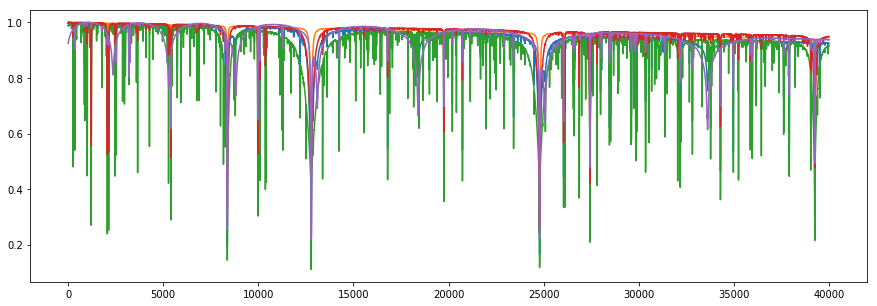

In [24]:
data_init = sess.run(data_batch)
print(data_init.shape)
plt.figure(figsize=(15, 5))
for spectrum in data_init[:5]:
    plt.plot(spectrum)

In [7]:
with tf.device("/device:GPU:0"):
    m = model.model(sess, hps, iterator.get_next(), data_init)

W0202 01:32:01.233811 140590606984960 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0202 01:32:01.312485 140590606984960 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



original shape (?, 256, 1)
encoding z (?, 64, 4)
creating revnet level 0 (?, 64, 4)
actnorm_scale (?, 64, 4) (1, 1, 4) 64
calculating prior (?, 64, 4)


W0202 01:32:01.804635 140590606984960 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


original shape (?, 256, 1)
encoding z (?, 64, 4)
creating revnet level 0 (?, 64, 4)
actnorm_scale (?, 64, 4) (1, 1, 4) 64
calculating prior (?, 64, 4)


In [8]:
%%time
m.train(.001)

CPU times: user 132 ms, sys: 4 ms, total: 136 ms
Wall time: 131 ms


array([0.436], dtype=float32)

In [9]:
n_processed = 0

hps.epochs = 100
hps.epochs_warmup = 5

for epoch in range(1, hps.epochs + 1):
    train_results = []
    initialize_iterator()
    #sess.run(iterator.initializer, feed_dict={placeholder_data: data})
    epoch_start_time = time.time()
    for iteration in range(hps.n_batches):
        lr = hps.lr * min(1., n_processed / (hps.batch_size * hps.n_batches * hps.epochs_warmup))
        start_time = time.time()
        train_results += [m.train(lr)]
        n_processed += hps.batch_size
        #print(epoch, iteration, np.round(time.time() - start_time, 3), train_results[-1][0])
    print(epoch, np.round(time.time() - epoch_start_time, 3), np.round(np.mean(train_results, axis=0), 3))

1 0.699 [0.424]
2 0.73 [0.32]
3 0.75 [0.063]
4 0.745 [-0.373]
5 0.715 [-0.872]
6 0.816 [-1.327]
7 0.813 [-1.608]
8 0.875 [-1.779]
9 0.832 [-1.9]
10 0.854 [-1.99]
11 0.563 [-2.062]
12 0.616 [-2.121]
13 0.734 [-2.171]
14 0.715 [-2.214]
15 0.68 [-2.251]
16 0.548 [-2.282]
17 0.7 [-2.31]
18 0.59 [-2.334]
19 0.641 [-2.355]
20 0.684 [-2.374]
21 0.705 [-2.391]
22 0.674 [-2.406]
23 0.712 [-2.419]
24 0.824 [-2.432]
25 0.748 [-2.443]
26 0.729 [-2.453]
27 0.714 [-2.462]
28 0.586 [-2.471]
29 0.758 [-2.478]
30 0.752 [-2.486]
31 0.695 [-2.493]
32 0.713 [-2.499]
33 0.784 [-2.506]
34 0.807 [-2.512]
35 0.729 [-2.518]
36 0.698 [-2.523]
37 0.774 [-2.529]
38 0.83 [-2.534]
39 0.772 [-2.539]
40 0.729 [-2.544]
41 0.656 [-2.548]
42 0.621 [-2.552]
43 0.595 [-2.556]
44 0.726 [-2.56]
45 0.708 [-2.564]
46 0.593 [-2.567]
47 0.719 [-2.571]
48 0.609 [-2.575]
49 0.747 [-2.579]
50 0.673 [-2.583]
51 0.734 [-2.587]
52 0.803 [-2.59]
53 0.71 [-2.593]
54 0.707 [-2.597]
55 0.695 [-2.6]
56 0.765 [-2.602]
57 0.712 [-2.605]
58 

In [10]:
i = np.random.randint(0, 50)
sample_data = data_init[i:i+1, :, :]
print(i)

9


In [11]:
latent_rep = sess.run(m.encode(m.X), feed_dict={m.X: sample_data})
spectrum = sess.run(m.decode(m.encode(m.X)), feed_dict={m.X: sample_data})

W0202 01:34:34.490384 140590606984960 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:119: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



creating revnet level 0 (?, 64, 4)
actnorm_scale (?, 64, 4) (1, 1, 4) 64
creating revnet level 0 (?, 64, 4)
actnorm_scale (?, 64, 4) (1, 1, 4) 64


W0202 01:34:34.709821 140590606984960 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:217: The name tf.matrix_inverse is deprecated. Please use tf.linalg.inv instead.



actnorm_scale (?, 64, 4) (1, 1, 4) 64


In [12]:
print(latent_rep.mean(), latent_rep.std())

-0.01984147 0.779066


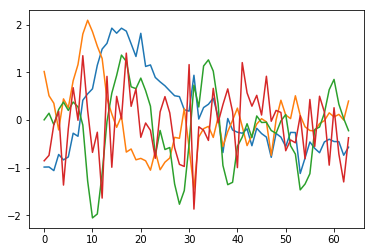

In [13]:
plt.plot(latent_rep[0, :, 0])
plt.plot(latent_rep[0, :, 1])
plt.plot(latent_rep[0, :, 2])
plt.plot(latent_rep[0, :, 3])

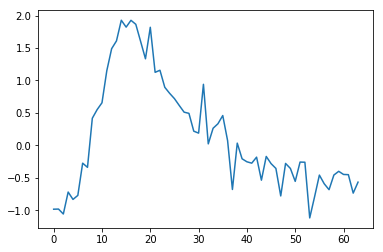

In [14]:
plt.plot(latent_rep[0, :, 0])
#plt.plot(latent_rep[0, :, 1])
#plt.plot(latent_rep[0, :, 2])
#plt.plot(latent_rep[0, :, 3])

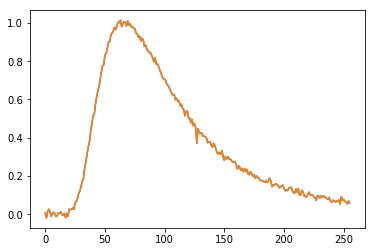

In [15]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(sample_data))

(102.4, 153.6)

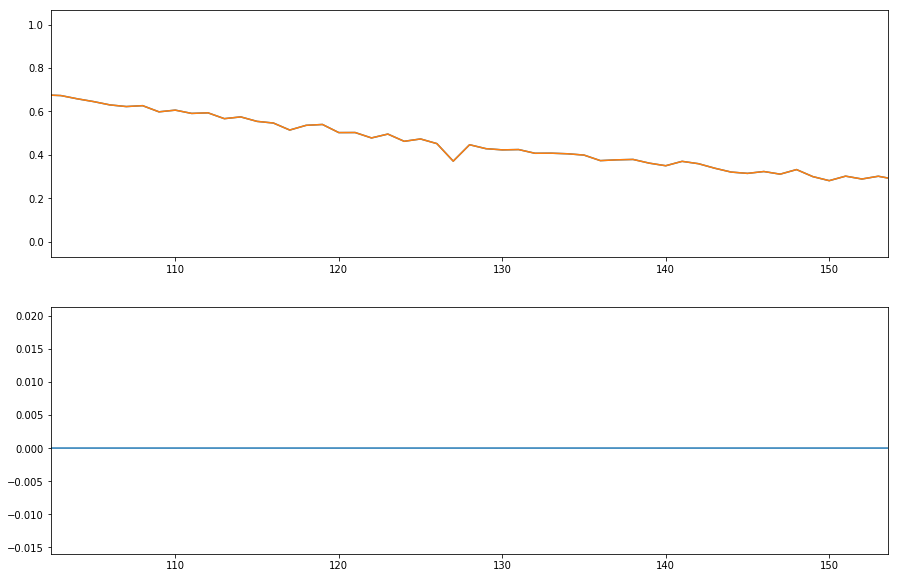

In [16]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)))
plt.plot(np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

plt.subplot(2, 1, 2)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)) - np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)